In [ ]:
import sys
sys.path.append('../../../')

from src import customFunc as cf, ansatzes as anz

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

import pickle

from matplotlib import cm

In [112]:
estimator = Estimator()

observable  = SparsePauliOp.from_list([("ZZII",1)])

def block(n: int, param_prefix: str = "θ"):
    qc = QuantumCircuit(n)
    for i in range(n):
        aux = np.random.random()
        if aux < 1/3:
            qc.rx(Parameter(param_prefix + "_" + str(i)), i)
        elif aux < 2/3:
            qc.ry(Parameter(param_prefix + "_" + str(i)), i)
        else:
            qc.rz(Parameter(param_prefix + "_" + str(i)), i)

    for i in range(0, n-1, 2):
        qc.cx(i, i+1)
    for i in range(1, n-1, 2):
        qc.cx(i, i+1)
    qc.name = "block"
    return qc

def alt(l: int, n: int, m: int):
    if m % 2 != 0:
        raise Exception("Parameter `m` must be an even number")
    if n % m != 0:
        raise Exception("Parameter `n` divided by `m` must be integer")
    
    qc = QuantumCircuit(n)
    for i in range(l):
        if (i + 1) % 2 == 0:
            qc.append(block(m//2, param_prefix=f"θ_{i}_0"), range(0, m//2))
            for j in range(m//2, n-m//2, m):
                qc.append(block(m, param_prefix=f"θ_{i}_{j}"), range(j, j+m))
            qc.append(block(m//2, param_prefix=f"θ_{i}_{j+1}"), range(n-m//2, n))
        else:
            for j in range(0, n, m):
                qc.append(block(m, param_prefix=f"θ_{i}_{j}"), range(j, j+m))
    return qc

def build_ala_ansatz(num_qubits):
    ansatz = alt(3, num_qubits, 2)
    return ansatz, ansatz.num_parameters

ansatz_circuit, n_params = build_ala_ansatz(4)

In [183]:
# Fijar valores aleatorios para todos los parámetros, excepto los dos primeros
rng = np.random.default_rng(seed=42)
full_params = rng.uniform(-np.pi, np.pi, n_params)

# Grid
resolution = 100
theta_range = np.linspace(-2*np.pi, 2*np.pi, resolution)
X = theta_range.copy()
Y = theta_range.copy()
Z = np.zeros((resolution, resolution), dtype=np.float128)

# Bucle doble para evaluar el observable
for i in range(resolution):
    for j in range(resolution):
        test_params = full_params.copy()
        test_params[2] = X[i]
        test_params[3] = Y[j]
        Z[i, j] = cf.evaluate_observable(test_params, ansatz_circuit, observable, estimator)

/tmp/ipykernel_1501818/712088394.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


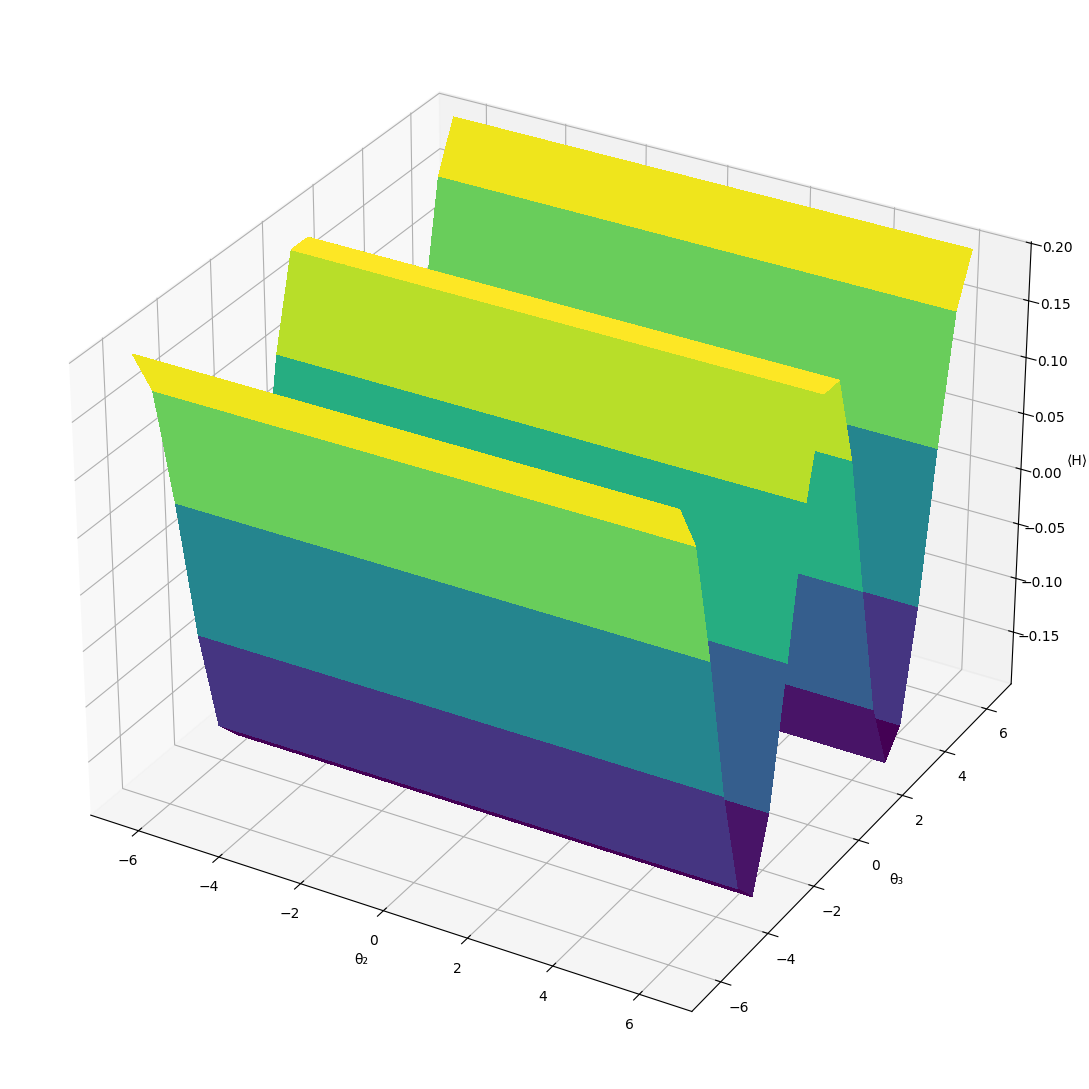

In [182]:
X = theta_range.copy()
Y = theta_range.copy()

X, Y = np.meshgrid(X,Y)

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw={"projection": "3d"}, constrained_layout=True)
surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, antialiased=False)
ax.set_xlabel("θ₂")
ax.set_ylabel("θ₃")
ax.set_zlabel("⟨H⟩")

ax.set_zlim(np.min(Z), np.max(Z))
plt.tight_layout()
plt.show()
